In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML



%matplotlib inline

In [4]:
G = nx.read_gml("./../data_desafio/GraphMissingEdges.gml")

In [5]:
categories_nodes = nx.get_node_attributes(G,'categories')
for key in categories_nodes:
    categories_nodes[key] = categories_nodes[key].split(',')

In [6]:
categories_df = pd.read_csv('./../data_desafio/categories.csv', sep=',')
categories_df = categories_df.set_index('CategoryId')

In [7]:
for node in G.nodes:
    categories = categories_nodes[node]
    categories_names = []
    for category in categories:
        if category != '':
            categories_names.append(categories_df.loc[int(category)]['names'])
    G.nodes[node]['categories_named'] = categories_names

C:\Users\rodri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Número de nós : 4575
Número de arestas : 18991
Número de componentes conectados : 756


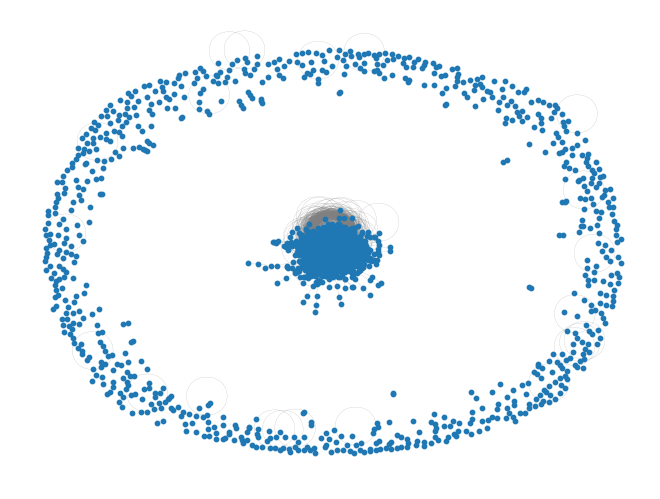

In [10]:
pos = nx.spring_layout(G)
nx.draw(G, cmap = plt.get_cmap('rainbow'), pos=pos, node_size=10, with_labels=False, edge_color='grey', width=0.1)

n = G.number_of_nodes()
m = G.number_of_edges()
print("Número de nós : %d" % n)
print("Número de arestas : %d" % m)
print("Número de componentes conectados : %d" % nx.number_connected_components(G))